# Metric learning for image similarity search

**Author:** [Mat Kelcey](https://twitter.com/mat_kelcey)<br>

## Setup

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers

## Dataset

使用[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) 資料集.

In [18]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test_raw = x_test.copy()

y_train = np.squeeze(y_train) # (50000, 1) -> (50000)
y_test = np.squeeze(y_test)

x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000,))

隨機選擇25張圖片

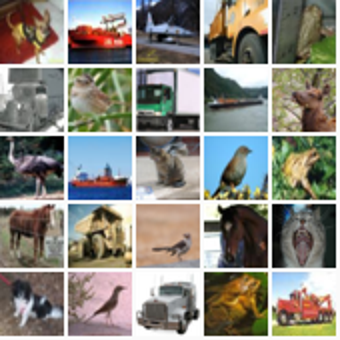

In [3]:
height_width = 32


def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx])).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((2 * num_cols * box_size, 2 * num_rows * box_size))
    return collage


# Show a collage of 5x5 random images.
sample_idxs = np.random.randint(0, 50000, size=(5, 5))
examples = x_train[sample_idxs]
show_collage(examples)

In [19]:
# 使用transfer learning 前處理
preprocess = keras.applications.mobilenet_v2.preprocess_input

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [5]:
# 建構各類別對應影像位置
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(y_train):
    class_idx_to_train_idxs[y].append(y_train_idx)

class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(y_test):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [6]:
# key: 類別
class_idx_to_test_idxs.keys()

dict_keys([3, 8, 0, 6, 1, 9, 5, 7, 4, 2])

In [7]:
# value: 此類別的圖片在第幾張
class_idx_to_test_idxs[0][:5]

[3, 10, 21, 27, 44]

目標：

在一個batch中

1. 拉近anchor, positive

2. 拉開anchor, negative

這邊的batch size跟類別個數相同 e.g: CIFAR10 = 10

In [8]:
num_classes = 10

class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        # 將每個類別依序取出
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            # 隨機選擇 anchor, positive 位置各一
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            # 若剛好anchor 與 positive 是同一張，持續隨機選擇
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            # 將anchor, positive 圖片放到對應的類別
            x[0, class_idx] = x_train[anchor_idx]
            x[1, class_idx] = x_train[positive_idx]
        return x


視覺化一個batch

examples shape (2, 10, 32, 32, 3)


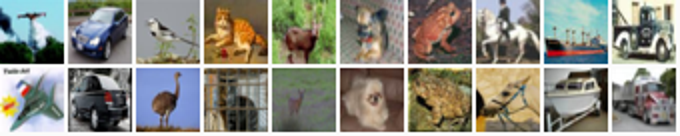

In [9]:
examples = AnchorPositivePairs(num_batchs=1)[0]
examples = ((examples/2 + 0.5) * 255).astype(int) # -1~1 -> 0~255
print("examples shape", examples.shape)
show_collage(examples)

## Embedding model

客製化Model的`train_step`

1. 取出anchor & positive 的embedding 向量

2. 計算anchor & positive 向量內積

In [10]:

class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]
        # data: (2, N, H, W, C)
        # anchor, postive: (N, H, W, C)

        with tf.GradientTape() as tape:
            # 計算 anchors, positives 的 embedding
            # anchor, positive embedding: (N, dim)
            anchor_embeddings = self(anchors, training=True)
            positive_embeddings = self(positives, training=True)

            # 用內積計算anchors, positives 相似度
            # similarities: (N, N)
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # 用超參數temperature做normalize
            temperature = 0.2
            similarities /= temperature

            # 解答為N類別index: [0, 1, 2, ..., num_classes-1]
            # 解答形式為對角矩陣
            # e.g 3類別:
            # [1, 0, 0]
            # [0, 1, 0]
            # [0, 0, 1]
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # 計算梯度+更新參數
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # 更新metrics
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}


建造模型

抽取特徵後將輸入投影至dim=8空間，再normalize

In [11]:
inputs = layers.Input(shape=(height_width, height_width, 3))
encoder = keras.applications.MobileNetV2(include_top=False, 
                                         weights='imagenet',
                                         input_shape=(height_width, height_width, 3))
x = encoder(inputs)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)
# 用上面EmbeddingModel封裝模型
model = EmbeddingModel(inputs, embeddings)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
# 1個epoch 1000 batches
history = model.fit(AnchorPositivePairs(num_batchs=1000), 
                    epochs=20)

plt.plot(history.history["loss"])
plt.show()

In [ ]:
model.save_weights("mobilev2_metric_32.h5")

## Testing

1. 計算整個test_set的圖片embedding
2. 計算test圖片兩兩間的相似度 

In [12]:
model.load_weights("mobilev2_metric_32.h5")

In [13]:
near_neighbours_per_example = 10

embeddings = model.predict(x_test)
# 計算圖片兩兩間的內積
gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
# 計算每一筆資料相似度排序最高的10筆結果 (小->大)
# 最大值就是自己本身 (100%相似)
near_neighbours = np.argsort(gram_matrix.T)[:, -(near_neighbours_per_example + 1) :]

313/313 [==============================] - 11s 7ms/step


In [14]:
embeddings.shape, gram_matrix.shape, near_neighbours.shape

((10000, 8), (10000, 10000), (10000, 11))

In [15]:
for i in range(3):
    print(near_neighbours[i])

[2795 4617 9198 7352 8966 1053 2897 8885 8257 9388    0]
[ 909 1840 7643 6961 2986 7949 1447 6244 5879 2875    1]
[5920 3562 6208 5002 5383 2745 4095 5078 9680 9012    2]


column 0: 原始查詢圖片

column 1~10: 資料庫中最接近的圖片 以相似度排序大->小

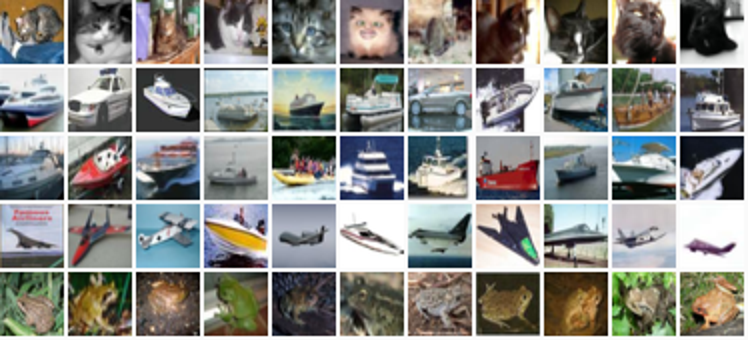

In [22]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = x_test_raw[row_idx]
    anchor_near_neighbours = reversed(near_neighbours[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = x_test_raw[nn_idx]

show_collage(examples)

計算各類別中，每張圖片與最接近該圖片的類別是否為同一個，計算混淆矩陣

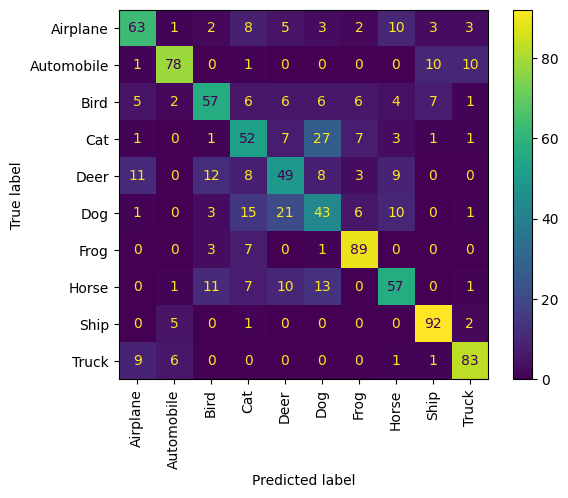

In [24]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # 挑選10筆資料
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # 計算與該圖片最相似的圖片類別
        for nn_idx in near_neighbours[y_test_idx][:-1]:
            nn_class_idx = y_test[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# 顯示混淆矩陣
labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()

Ref: 
* [What is metric learning?](http://contrib.scikit-learn.org/metric-learn/introduction.html)
* ["Using crossentropy for metric learning" tutorial](https://www.youtube.com/watch?v=Jb4Ewl5RzkI)

Example available on HuggingFace.

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-Cifar10%20Metric%20Learning-black.svg)](https://huggingface.co/keras-io/cifar10_metric_learning) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-Metric%20Learning%20for%20Image%20Similarity%20Search-black.svg)](https://huggingface.co/spaces/keras-io/metric-learning-image-similarity-search) |